<a href="https://colab.research.google.com/github/HanJaeHui-GitHub/ESAA/blob/main/ESAA_YB_Week10_markdown(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10주차 과제_1108(금)

 파이썬 머신러닝 완벽가이드 ch5. 6\~8 pg. 337\~362

## 규제 선형 모델 -  릿지, 라쏘, 엘라스틱넷

### 규제 선형 모델의 개요

앞서서는 선평 모델의 비용함수는 RSS를 최소화하는, 즉 실제 값과 예측값의 차이를 최소화하는 것만 고려함

→ 학습 데이터에 지나치게 맞추게 되고 회귀 계수가 쉽게 커짐

→ 변동성이 오히려 심해져서 테스트 데이터 세트에서는 예측 성능이 저하되기 쉬움

따라서 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 **RSS 최소화 방법**과 과적합을 방지하기 위해 **회귀 계수 값이 커지지 않도록 하는 방법**이 서로 균형을 이루어야 함

$$비용\ 함수\ 목표=Min(RSS(W)+alpha*\|W\|_2^2)$$

$alpha$ : 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터

- $alpha$가 0(또는 매우 작은 값)이라면 비용 함수 식은 기존과 동일하게 RSS를 최소화하는 식이 됨

- $alpha$가 무한대(또는 매우 큰 값)라면 $RSS(W)$보다 $alpha*\|W\|_2^2$ 값이 커지므로 $W$ 값을 0(또는 매우 작게) 만들어야 비용 함수가 최소화 됨

즉, $alpha$ 값을 크데 하면 비용 함수는 회귀 계수 $W$의 값을 작게 해 과적합을 개선할 수 있고 $alpha$값을 작게 하면 회귀 계수 $W$의 값이 커져도 어느 정도 상쇄 가능함

규제(Regularization) : 비용 함수에 $alpha$ 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식

- L2 규제(=릿지(Ridge)) : $alpha*\|W\|_2^2$와 같이 $W$의 제곱에 대해 페널티를 부여하는 방식

- L1 규제(=라쏘(Lasso)) : $alpha*\|W\|_1$와 같이 $W$의 절대값에 대해 페널티 부여, L1 규제를 적용하면 영향력이 크지 않은 회귀 계수 값을 0으로 변환함

### 릿지 회귀

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
import requests
warnings.filterwarnings('ignore')

%matplotlib inline

# 데이터 URL
url = "https://lib.stat.cmu.edu/datasets/boston"

# 데이터를 텍스트 형식으로 불러오기
response = requests.get(url)
data_text = response.text

# 데이터 텍스트를 줄 단위로 나누기
data_lines = data_text.splitlines()

# 데이터의 구조 확인
# 헤더가 첫 번째와 두 번째 줄에 설명되어 있고, 그 뒤로 데이터가 시작됨
print(data_lines[:10])  # 상위 10개 줄을 확인하여 데이터 구조를 이해

# 데이터는 2줄에 걸쳐 1개의 레코드가 기록되어 있음
data = []
for i in range(22, len(data_lines), 2):  # 22번째 줄부터 데이터 시작
    row1 = list(map(float, data_lines[i].strip().split()))
    row2 = list(map(float, data_lines[i+1].strip().split()))
    data.append(row1 + row2)  # 2줄의 데이터를 하나의 레코드로 합침

# 컬럼 이름 정의 (Boston housing dataset의 특성 이름 사용)
columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
    "PTRATIO", "B", "LSTAT", "PRICE"
]

# 데이터프레임으로 변환
bostonDF = pd.DataFrame(data, columns=columns)

# 데이터 확인
bostonDF.head()

[" The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic", " prices and the demand for clean air', J. Environ. Economics & Management,", " vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics", " ...', Wiley, 1980.   N.B. Various transformations are used in the table on", ' pages 244-261 of the latter.', '', ' Variables in order:', ' CRIM     per capita crime rate by town', ' ZN       proportion of residential land zoned for lots over 25,000 sq.ft.', ' INDUS    proportion of non-retail business acres per town']


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# alpha = 10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores,3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE : 5.518


In [4]:
# alpha 값의 변화에 따른 5 폴드의 RMSE 평균값을 반환하는 코드
# 릿지에 사용될 alpha 파라미터의 값 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha{0}일 때 5 folds의 평균 RMSE:{1:.3f}'.format(alpha, avg_rmse))

alpha0일 때 5 folds의 평균 RMSE:5.829
alpha0.1일 때 5 folds의 평균 RMSE:5.788
alpha1일 때 5 folds의 평균 RMSE:5.653
alpha10일 때 5 folds의 평균 RMSE:5.518
alpha100일 때 5 folds의 평균 RMSE:5.330


alpha가 100일 때 평균 RMSE가 5.330으로 가장 좋음

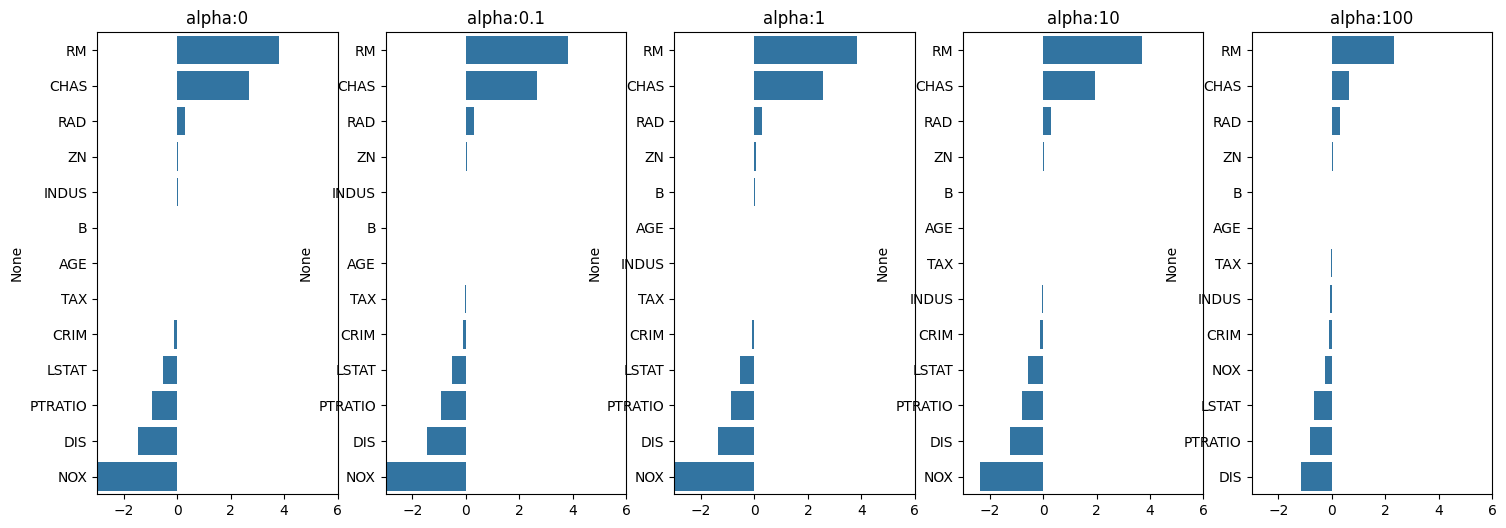

In [5]:
# alpha 값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화하기
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize = (18,6), nrows = 1, ncols = 5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장 pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x = coeff.values, y = coeff.index, ax = axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha 값을 계속 증가시킬수록 회귀 계수 값이 지속적으로 작아짐을 알 수 있음

특히 NOX 피처의 경우 alpha 값을 계속 증가시킴에 따라 회귀 계수가 크게 작아짐

In [6]:
# DataFrame에 저장된 alpha 값의 변화에 따른 릿지 회귀 계수 값 구하기
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아짐을 확인할 수 있지만 회귀 계수가 0이 되지는 않음

### 라쏘 회귀

L2 규제가 회귀 계수의 크기를 감소시키는데 반해 L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함

즉, L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가짐

In [7]:
# alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수 출력하는 코드
from sklearn.linear_model import Lasso, ElasticNet

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params = None, X_data_n = None, y_target_n = None, verbose = True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('######', model_name, '######')
    for param in params :
        if model_name == 'Ridge': model = Ridge(alpha = param)
        elif model_name == 'Lasso' : model = Lasso(alpha = param)
        elif model_name == 'ElasticNet' : model = ElasticNet(alpha = param, l1_ratio = 0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = 'neg_mean_squared_error', cv = 5)
        avg_rmse = np.mean (np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트 평균 RMSE:{1:.3f}'.format(param, avg_rmse))
        # cross_val_score는 evaluation metirc만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

        model.fit(X_data_n, y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
            coeff = pd.Series(data = model.coef_, index = X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df
# end of get_linear_regre_eval

In [8]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

###### Lasso ######
alpha 0.07일 때 5 폴드 세트 평균 RMSE:5.612
alpha 0.1일 때 5 폴드 세트 평균 RMSE:5.615
alpha 0.5일 때 5 폴드 세트 평균 RMSE:5.669
alpha 1일 때 5 폴드 세트 평균 RMSE:5.776
alpha 3일 때 5 폴드 세트 평균 RMSE:6.189


alpha가 0.07일 때 5.612로 가장 좋은 평균 RMSE를 보여줌

앞선 릿지 평균 5.518보다 약간 떨어지는 수치지만 LinearRegression 평균인 5.829보다는 향상됨

In [9]:
# 반환된 coeff_lasso_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by = sort_column, ascending = False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수가 0으로 바뀜

NOX 속성은 alpha가 0.07일 때부터 회귀 계수가 0이며 alpha를 증가시키면서 INDUS, CHAS와 같은 속성의 회귀 계수가 0으로 바뀜

### 엘라스틱넷 회귀

엘라스틱넷(Elastic Net) 회귀 : L2, L1 규제를 결합한 회귀

$RSS(W)+alpha2*\|W\|_2^2+alpha1*\|W\|_1$를 최소화하는 $W$를 찾는 것

라쏘 회귀를 이용해 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강해 alpha 값에 따라 회귀 계수의 값이 급격히 변동할 수 있는데 이를 완화하기 위해 L2 규제를 추가함

단점으로는 수행시간이 상대적으로 오래 걸린다는 것이다.

In [10]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas, X_data_n = X_data, y_target_n = y_target)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트 평균 RMSE:5.542
alpha 0.1일 때 5 폴드 세트 평균 RMSE:5.526
alpha 0.5일 때 5 폴드 세트 평균 RMSE:5.467
alpha 1일 때 5 폴드 세트 평균 RMSE:5.597
alpha 3일 때 5 폴드 세트 평균 RMSE:6.068


In [11]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀 계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by = sort_column, ascending = False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha 0.5일 때 RMSE가 5.467로 가장 좋은 예측 성능을 보임

alpha 값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음

### 선형 회귀 모델을 위한 데이터 변환

선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고 이러한 최적의 선형 함수를 찾아내 결괏값을 예측함

또한 피처값과 타깃값의 분포가 정규 분포(평균을 중심으로 종 모양으로 데이터 값이 분포된 형태)형태를 선호함

특히 타깃값의 경우 정규 분포 형대가 아닌 특정값의 분포가 치우친 왜곡(Skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높음

피처값 또한 결정값보다는 덜하지만 왜곡된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 수 있음 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적임

<사이킷런을 이용해 피처 데이터 세트에 적용하는 변환 작업>

1. StandardScaler 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0이고 최댓값이 1인 값으로 정규화 수행

2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환, 보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 적용함

3. 원래 값에 log 함수를 적용하면 정규 분포에 가까운 형태로 값이 분포됨. 이러한 변환을 로그 변환(Log Transformation)이라고 부름 1번 방법은 예측 성능 향상을 크게 기대하기 어려운 경우가 많으며 2번 방법은 피처의 개수가 많을 경우 다항 변환으로 생성되는 피처의 개수가 기하급수로 늘어나 과적합의 이슈가 발생할 수 있기 때문에 가장 많이 사용되는 방법임

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 떄 적용, p_degree는 2 이상 부여하지 않음
def get_scaled_data(method = 'None', p_degree = None, input_data = None) :
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    else :
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree, include_bias = False).fit_transform(scaled_data)
    return scaled_data

In [26]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환, 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data = X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose = False, return_coeff = False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트 평균 RMSE:5.788
alpha 1일 때 5 폴드 세트 평균 RMSE:5.653
alpha 10일 때 5 폴드 세트 평균 RMSE:5.518
alpha 100일 때 5 폴드 세트 평균 RMSE:5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트 평균 RMSE:5.826
alpha 1일 때 5 폴드 세트 평균 RMSE:5.803
alpha 10일 때 5 폴드 세트 평균 RMSE:5.637
alpha 100일 때 5 폴드 세트 평균 RMSE:5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트 평균 RMSE:8.827
alpha 1일 때 5 폴드 세트 평균 RMSE:6.871
alpha 10일 때 5 폴드 세트 평균 RMSE:5.485
alpha 100일 때 5 폴드 세트 평균 RMSE:4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트 평균 RMSE:5.764
alpha 1일 때 5 폴드 세트 평균 RMSE:5.465
alpha 10일 때 5 폴드 세트 평균 RMSE:5.754
alpha 100일 때 5 폴드 세트 평균 RMSE:7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트 평균 RMSE:5.298
alpha 1일 때 5 폴드 세트 평균 RMSE:4.323
alpha 10일 때 5 폴드 세트 평균 RMSE:5.185
alpha 100일 때 5 폴드 세트 평균 RMSE:6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트 평균 RMSE:5.788
alpha 1일 때 5 폴드 세트 평균 RMSE:5.653
alpha 10

표준 정규 분포와 최솟값/최댓값 정규화로 피처 데이터 세트를 변경해도 성능상 개선 없음

표준 정규 분포로 일차 변환 후 2차 다항식 변환을 했을 때 alpha = 100에서 4.634으로 성능이 개선되었고 최솟값/최댓값 정규화로 일차 변환 후 2차 다항식 변환을 했을 때 alpha = 1에서 4.323으로 성능이 개선됨

하지만 다항식 변환은 피처의 개수가 많을 경우 적용하기 힘들며 데이터 건수가 많아지면 계산에 많은 시간이 소모되어 적용에 한계가 있음

반면 로그 변환을 보면 alpha가 0.1, 1, 10인 경우 모두 좋은 성능 향상이 있음을 알 수 있음

## 로지스틱 회귀

로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘임

선형 회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아닌 시그모이드(Sigmoid) 함수 최적선을 찾고 이 시그모디으 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 것임

$$y=\frac{1}{1+e^{-x}}$$

x 값이 아무리 커지거나 작아져도 y 값은 항상 -과 1 사이 값을 반환함, x가 커지면 1에 근사하며 x이 작아지면 0에 근사, x가 0일때는 0.5임

<분류 문제에 적용해보기>

종양의 크기에 따라 악성 종양인지(Yes = 1) 그렇지 않은지(No = 0)를 회귀를 이용해 1과 0의 값으로 예측 실시

X : 종양의 크기

Y : 악성 종양 여부

|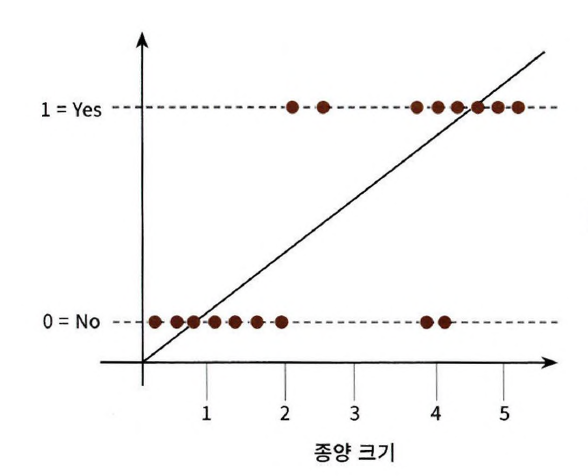|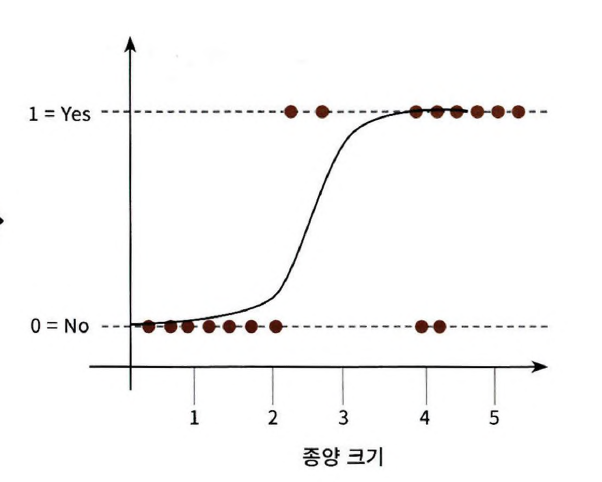|
|--|--|
|선형 회귀선은 0과 1을 제대로 분류하지 못함|S자 커브 형태의 시그모이드 함수를 이용해 좀 더 정확하게 0과 1에 대해 분류 할 수 있음|

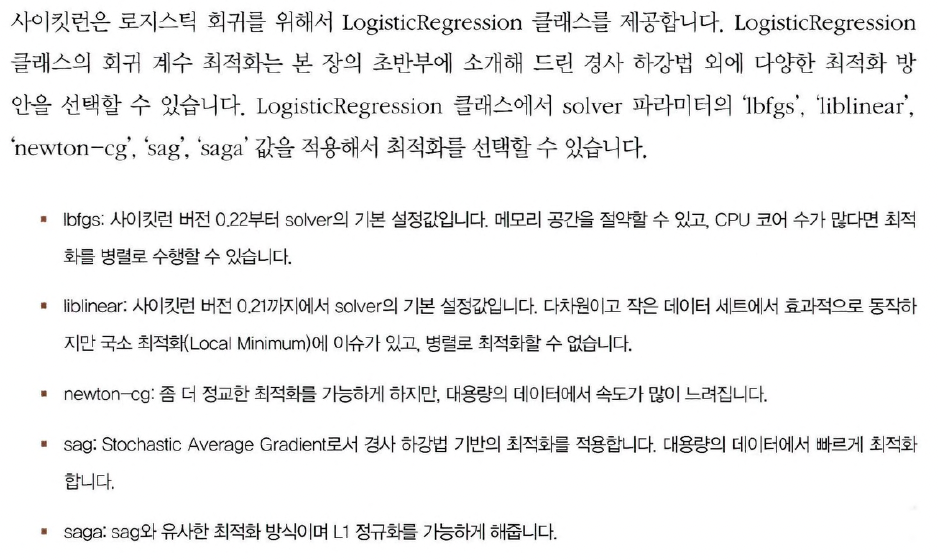

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용해 학습 및 예측 수행.
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


In [33]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러 개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver = solver, max_iter = 600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy:{1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

solver:lbfgs, accuracy:0.977, roc_auc:0.995
solver:liblinear, accuracy:0.982, roc_auc:0.995
solver:newton-cg, accuracy:0.977, roc_auc:0.995
solver:sag, accuracy:0.982, roc_auc:0.995
solver:saga, accuracy:0.982, roc_auc:0.995


In [34]:
# GridSearchCV를 이용해 위스콘신 데이터 세트에서 solver, penalty, C 최적화하기
from sklearn.model_selection import GridSearchCV

params = {'solver':['liblinear', 'lbfgs'],
          'penalty':['l2','l1'],
          'C':[0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring = 'accuracy', cv = 3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


## 회귀 트리

회귀 트리 : 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 것

분류 트리와 리프 노드에서 예측 결정 값을 만드는 과정에 차이가 있음. 분류 트리가 특정 클래스 레이블을 결정하는 것과는 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산함

결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등의 트리 기반 알고리즘은 CART(Classification And Regression Trees) 알고리즘에 기반하고 있기 때문에 분류뿐만 아니라 회귀도 가능함

In [40]:
# RandomForestRegressor를 이용해 보스턴 주택 가격 예측 수행
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 보스턴 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
bostonDF = pd.DataFrame(boston, columns = feature_names)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [41]:
# 랜덤 포레스트, 결정 트리, GBM, XGBoost, LightGBM의 Regressor를 모두 이용해 보스턴 주택 가격 예측
def get_model_cv_prediction(model, X_data, y_target) :
  neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('#####', model.__class__.__name__, '#####')
  print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [42]:
# 다양한 유형의 회귀 트리 생성하고 이를 이용해 보스턴 주택 가격 예측하기
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models :
  get_model_cv_prediction(model, X_data, y_target)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

<Axes: xlabel='None', ylabel='None'>

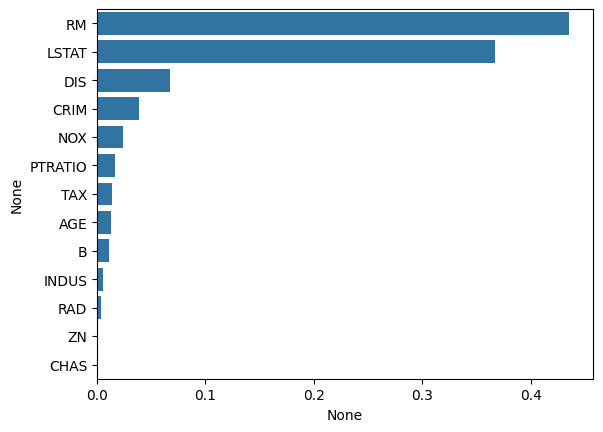

In [43]:
# 피처별 중요도 시각화하기
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators = 1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series, y = feature_series.index)

(100, 2)


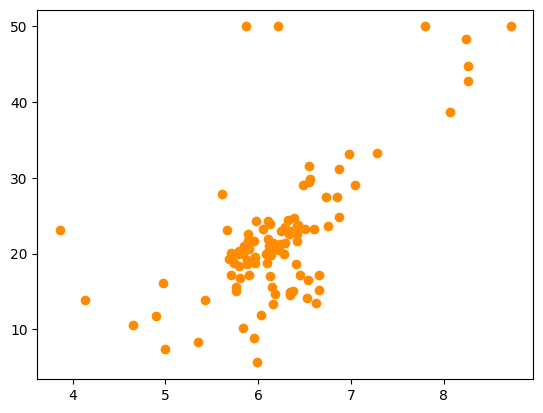

In [44]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")

In [45]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_dapth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

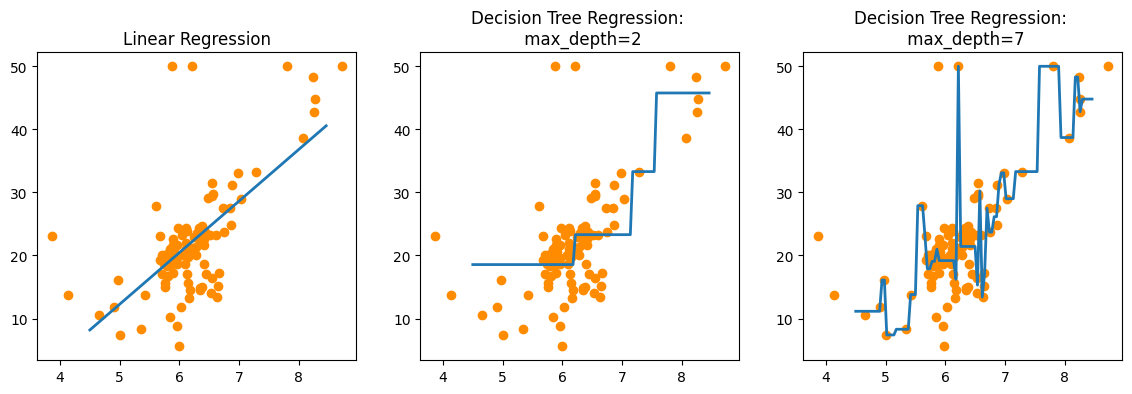

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

# X 축 값을 4.5 ~ 8.5로 변환하며 입력했을 떄 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 떄 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label='max_depth:3', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)